# Gathering Data

In [1]:
from functions import *
from scivol import *
import nibabel as nib
import ipyvolume as ipv
import numpy as np
import json
import nilearn
from nilearn import masking

In [2]:
proj_root = parent_directory()
print(proj_root)
mri_input_filepath = os.path.join(proj_root, "media/sub-01/anat/sub-01_T1w.nii.gz")
output_folder = os.path.join(proj_root, "output/")
mask_seq_path = "/Users/joachimpfefferkorn/repos/neurovolume/output/slice_images_mask"

/Users/joachimpfefferkorn/repos/neurovolume


In [35]:
anat_img = nib.load(mri_input_filepath)
print(anat_img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 296)
affine:
[[ 4.78498012e-01 -1.21539005e-03  0.00000000e+00 -1.19988998e+02]
 [ 1.21539005e-03  4.78498012e-01  0.00000000e+00 -1.04519997e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e-01 -8.42456970e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 512 512 296   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.     0.4785 0.4785 0.5    0.     0.     0.     0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units    

It is revealed here that our datatype is a 16 bit int

From copilot:
"Number of distinct values between 0.0 and 1.0 in a 64-bit float: 4,503,599,627,370,496."  This is more than the 65,536 values stored in a 16bit int. I think we're good

# Skull Stripping
Using [nilearn](https://nilearn.github.io/stable/index.html)

In [ ]:
#full_anat = create_volume(normalize_array(anat_img.get_fdata()))
brain_mask = nilearn.masking.compute_brain_mask(anat_img, threshold=0.2, mask_type="whole-brain")

In [57]:
print(brain_mask)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 296)
affine:
[[ 4.78498012e-01 -1.21539005e-03  0.00000000e+00 -1.19988998e+02]
 [ 1.21539005e-03  4.78498012e-01  0.00000000e+00 -1.04519997e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e-01 -8.42456970e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 512 512 296   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.         0.47849956 0.47849956 0.5        1.         1.         1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code 

In [ ]:
print(np.allclose(brain_mask.affine, anat_img.affine))

True


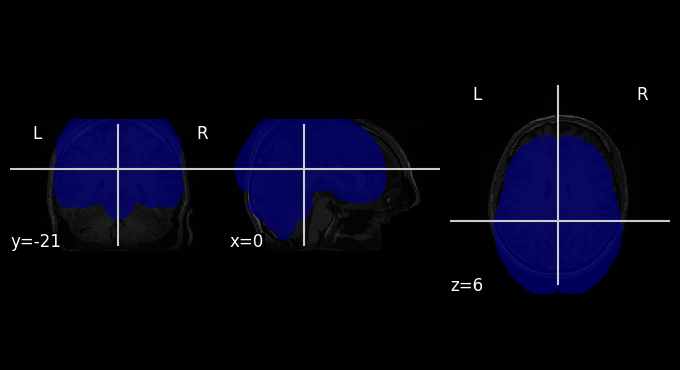

In [44]:
from nilearn.plotting import plot_roi
plot_roi(brain_mask, anat_img)

In [21]:
brain_anat = create_masked_normalized_tensor(full_anat, brain_mask.get_fdata())
ipv.quickvolshow(brain_anat)

creating masked normal tensor


/Users/joachimpfefferkorn/repos/neurovolume/.venv/lib/python3.11/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

(512, 512, 296)


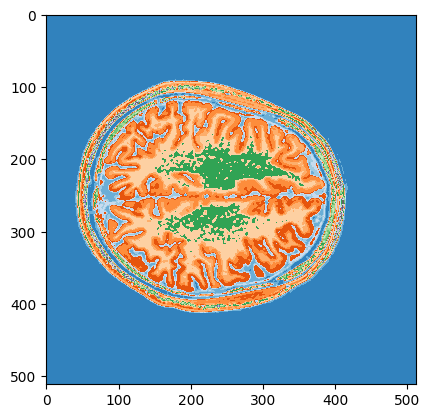

In [13]:
print(full_anat.shape)
view_slice(full_anat[:,:,200])

Nilearn does seem to be cutting off the top of the brain, and this isn't exactly super high quality, but it is separate!

I wonder if this should be in MNI space before. That being said, it looks pretty good in blender! Switching over to T1W images is much better (rookie mistake on my part)

https://nilearn.github.io/stable/modules/generated/nilearn.masking.compute_brain_mask.html

In [23]:
ipv.quickvolshow(full_anat)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

# Building Scivol

In [56]:
affine = anat_img.affine
print(type(affine))

<class 'numpy.ndarray'>


Initialize the scivol object

In [57]:
skullstrip = Scivol("skullstrip", anat_img.affine, 0.2)

Create and add the grids

In [58]:
skullstrip.add_grids([Grid("full_anat",[full_anat]),
Grid("brain_anat", [brain_anat])])

writing full_anat to grid
writing brain_anat to grid


In [59]:
skullstrip.save_scivol(output_folder)

saving skullstrip.scivol
writing skullstrip.scivol


Before moving to blender to render these images, let's make sure that we can parse these scivol files here

In [60]:
scivol_path = "/Users/joachimpfefferkorn/repos/neurovolume/output/skullstrip.scivol"
with open(scivol_path, 'r') as file:
    data = json.load(file)
print("scivol name: ", data['name'], "\n")
for grid_key in data['grids'].keys():
    print(grid_key)
    vol = np.array(data['grids'][grid_key]['frames'][0])

scivol name:  skullstrip 

full_anat
brain_anat


In [61]:
print(data['tolerance'])
print((np.asarray(data['affine'])))

0.2
[[ 4.78498012e-01 -1.21539005e-03  0.00000000e+00 -1.19988998e+02]
 [ 1.21539005e-03  4.78498012e-01  0.00000000e+00 -1.04519997e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e-01 -8.42456970e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [62]:
print(data['grids'].keys())
for grid in data['grids']:
    print(grid)

dict_keys(['full_anat', 'brain_anat'])
full_anat
brain_anat


Cool, let's quickly visualize this

In [ ]:
ipv.quickvolshow(np.array(data['grids']['full_anat']['frames'][0]))
# only 0 as it's just 3D, no temporal dimension involved here

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107f91850>>
Traceback (most recent call last):
  File "/Users/joachimpfefferkorn/repos/neurovolume/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107f91850>>
Traceback (most recent call last):
  File "/Users/joachimpfefferkorn/repos/neurovolume/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Wow, that is taking a while to visualize. I wonder what's up?

In Blender, it appears that the brain is offset from the full_anat. Why is this?

Also, there is no gradation in density data